In [4]:
%load_ext autoreload

In [5]:
#from cap_package import SpotipyCollectPub as scp
from cap_package import ReadTransform as rt
from collections import OrderedDict
from datetime import datetime
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
%matplotlib inline

In [6]:
%autoreload 2

In [7]:
from IPython.utils.text import columnize
def disp_col(list_):
    
    # import -> from IPython.utils.text import columnize
    l = list(map(lambda x:repr(x)+ ',', list_))
    print(columnize(l, displaywidth=120))
def timer(start_time=None):
    if start_time is None:
        start_time = datetime.now()
        return start_time
    else:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [8]:
load_dotenv()
path = Path(os.getenv('PATH_DATASET1.2')).joinpath('user_pl_featstats')

In [9]:
#enc_labels = np.loadtxt(path.joinpath('enc_labels.csv'), delimiter=',')
enc_categories = np.loadtxt(path.joinpath('enc_categories.csv'), delimiter=',', dtype='U')

In [10]:
path_ = path.joinpath('user_pl_segstat')
dfs = []
for f in path_.iterdir():
    dfs.append(pd.read_parquet(f))

segstat_df = pd.concat(dfs, ignore_index=True)

In [11]:
path_ = path.joinpath('user_pl_feat')
dfs = []
for f in path_.iterdir():
    
    df = pd.read_parquet(f)
    pl_col = [f.name.replace('_features.parquet', '')] * len(df)
    df.insert(loc=0, column='playlist', value=pl_col)
    dfs.append(df)
    

full_feat_df = pd.concat(dfs, ignore_index=True)
feat_df = full_feat_df.loc[:, : 'artists_name']

##### We will merge segstats and feature dataframes to create one dataset
But before that we must ensure that columns we will use as keys match in both dataframes

In [12]:
# rename 'name' column to match 'track name' column in segstat_df
feat_df = feat_df.rename(columns={'name': 'track_name'})

# update track name column values to match that of in segstat_df

# add first 3 characters from artists_name
upd_trname = feat_df.track_name + '_' + feat_df.artists_name.apply(lambda x: x[:3])
# remove any special characters
upd_trname.replace(regex=r'[*|><:"?/]|\\', value='', inplace=True)
# find duplicates and add 'dup' to those track names
ind = upd_trname[upd_trname.duplicated()].index
upd_trname.iloc[ind] = upd_trname.iloc[ind].apply(lambda x: x + '_dup')

feat_df['track_name'] = upd_trname

In [13]:
new_df = pd.merge(feat_df, segstat_df, how='outer', on=['track_name', 'playlist'])
disp_col(new_df.columns)

'playlist',          'key_10',              'timbre_04_max',   'timbre_11_mean',      'timbre_06_skewness',
'danceability',      'key_11',              'timbre_05_max',   'timbre_12_mean',      'timbre_07_skewness',
'energy',            'track_name',          'timbre_06_max',   'timbre_01_min',       'timbre_08_skewness',
'loudness',          'artists_name',        'timbre_07_max',   'timbre_02_min',       'timbre_09_skewness',
'speechiness',       'timbre_01_kurtosis',  'timbre_08_max',   'timbre_03_min',       'timbre_10_skewness',
'acousticness',      'timbre_02_kurtosis',  'timbre_09_max',   'timbre_04_min',       'timbre_11_skewness',
'instrumentalness',  'timbre_03_kurtosis',  'timbre_10_max',   'timbre_05_min',       'timbre_12_skewness',
'valence',           'timbre_04_kurtosis',  'timbre_11_max',   'timbre_06_min',       'timbre_01_std',     
'tempo',             'timbre_05_kurtosis',  'timbre_12_max',   'timbre_07_min',       'timbre_02_std',     
'key_0',             'timbre

In [14]:
new_df.tail()

,playlist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,key_0,...,timbre_03_std,timbre_04_std,timbre_05_std,timbre_06_std,timbre_07_std,timbre_08_std,timbre_09_std,timbre_10_std,timbre_11_std,timbre_12_std
367,That familiar trance,0.489011,0.871102,0.348074,0.076179,0.096996,0.031860,0.410039,0.167805,0.0,...,53.760912,28.658233,24.945681,24.083093,23.611131,12.169136,12.933405,11.338227,15.863007,13.098306
368,That familiar trance,0.536630,0.796258,0.411248,0.047158,0.034256,0.929740,0.043677,0.169388,0.0,...,38.556718,30.325408,19.408703,27.986655,18.836288,18.970260,13.694174,19.440721,12.966388,12.459445
369,That familiar trance,0.668498,0.602911,0.425424,0.085852,0.594702,0.901843,0.481747,0.334444,0.0,...,41.415842,39.999842,14.649795,39.054745,18.875630,18.520975,15.517733,16.299007,17.545930,11.477168
370,That familiar trance,0.401099,0.835759,0.502311,0.054817,0.003291,0.908042,0.356258,0.280453,0.0,...,27.215150,30.004148,17.366065,16.325543,20.910253,13.603091,9.409996,12.026940,12.610697,10.760450
371,That familiar trance,0.941392,0.808732,0.582280,0.158807,0.401375,0.877045,0.908735,0.168389,0.0,...,57.739638,68.541280,29.603303,58.980708,20.423573,29.040059,15.927373,23.444979,32.022451,13.650441


In [15]:
data_df = new_df.drop(['track_name', 'artists_name', 'playlist'], axis=1)
labels = new_df.loc[:, 'playlist']
enc_labels = LabelEncoder().fit_transform(labels)

In [16]:
#data_df.info()

In [17]:
#enc_labels

In [18]:
SEED = 17

In [19]:
x_train, x_test, y_train, y_test = train_test_split( \
            data_df, enc_labels, test_size = 0.25, stratify=enc_labels, random_state=SEED)

In [20]:
print('Number of samples in train set:', len(x_train))
print('Number of samples in test set:', len(x_test))

Number of samples in train set: 279
Number of samples in test set: 93


In [21]:
x_train

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,key_0,key_1,...,timbre_03_std,timbre_04_std,timbre_05_std,timbre_06_std,timbre_07_std,timbre_08_std,timbre_09_std,timbre_10_std,timbre_11_std,timbre_12_std
258,0.388199,0.175793,0.615055,0.093416,0.102944,0.971784,0.306946,0.666083,1.0,0.0,...,61.340373,68.300065,26.620675,50.887021,23.877374,21.064195,12.599741,21.004123,28.460138,11.672324
271,0.180124,0.876081,0.722451,0.045679,0.001973,0.352071,0.508761,0.667666,0.0,0.0,...,40.239722,44.322552,33.001988,30.659777,20.125526,33.644765,17.605394,24.384863,21.002188,12.908547
156,1.000000,0.740741,0.241922,0.128689,0.003242,0.980948,0.345712,0.815366,0.0,0.0,...,55.014333,46.248933,32.763842,38.745378,26.849455,18.725869,15.353078,18.427314,18.189155,10.244100
115,0.719101,0.898917,0.686553,1.000000,0.020815,0.905063,0.768369,0.999253,0.0,0.0,...,55.504416,54.336562,22.771942,33.762291,18.057893,23.174254,12.080472,15.556047,15.687841,9.589107
152,0.471366,1.000000,0.795153,0.526564,0.001820,0.857108,0.216033,0.985750,1.0,0.0,...,30.781580,25.617694,22.531152,28.882643,19.706271,11.080467,12.163504,9.813689,11.756157,8.675394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,0.775510,0.871212,0.845036,1.000000,0.078307,0.417360,0.493649,0.557206,1.0,0.0,...,47.330960,39.965315,20.513505,17.217273,19.342854,20.890989,13.086608,19.961439,21.553471,11.919679
144,0.445255,0.755906,1.000000,0.078986,0.014005,0.910290,0.161723,0.202385,0.0,0.0,...,34.894702,33.980697,17.972710,19.588139,15.214347,14.311313,11.930288,11.312676,14.200111,10.688422
34,0.371429,0.965909,0.864813,0.056208,0.012950,0.908118,0.262224,0.664164,0.0,0.0,...,28.514594,23.379204,22.147793,24.768867,14.578971,13.134311,13.066983,12.126400,13.254983,11.122002
171,0.451542,0.788671,0.389642,0.079103,0.000435,0.910031,0.454760,0.985722,0.0,0.0,...,41.665234,31.740888,30.281403,23.139722,19.589989,17.464241,11.256729,12.438921,14.368568,12.043055


#### Baseline with most frequent/common class predicted

In [22]:
unique, train_counts = np.unique(y_train, return_counts=True, axis=0)
unique, test_counts = np.unique(y_test, return_counts=True, axis=0)
lab = [enc_categories[x] for x in unique]
df_list = [x for x in zip(lab, train_counts, test_counts)]
df = pd.DataFrame(df_list, columns=['label', 'train_counts', 'test_counts'])
df

,label,train_counts,test_counts
0,Classic progressive,26,9
1,Deep house,20,7
2,House-Trance,37,12
3,Our old school trance,27,9
4,Our old school trance 138,14,4
5,Our old school trance 2,17,6
6,Progressive 1,13,4
7,Progressive 2,20,6
8,Progressive 3,16,5
9,Progressive 4,24,8


In [23]:
print("Training accuracy with common class: ", df.train_counts.max()/len(y_train))
print("Test accuracy with common class: ", df.test_counts[df.train_counts.argmax()]/len(y_test))

Training accuracy with common class:  0.13261648745519714
Test accuracy with common class:  0.12903225806451613


#### Baseline with uniformly distributed predictions

In [24]:
np.random.seed(SEED)
train_lab_uni = np.random.randint(13, size=len(y_train))
test_lab_uni = np.random.randint(13, size=len(y_test))

In [25]:
print("Training accuracy with uniform dist: ", np.array(y_train==train_lab_uni).sum()/len(y_train))
print("Testing accuracy with uniform dist: ", np.array(y_test==test_lab_uni).sum()/len(y_test))

Training accuracy with uniform dist:  0.07526881720430108
Testing accuracy with uniform dist:  0.11827956989247312


#### Starting with a simple logistic regression model

In [26]:
logreg = LogisticRegression(class_weight='balanced', C=1, multi_class='multinomial', random_state=SEED, max_iter=1000)
clf = logreg.fit(x_train, y_train)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [27]:
print(' Accuracy on training data : \n' , classification_report(y_train, clf.predict(x_train), target_names=enc_categories))
print(' Accuracy on test data : \n' , classification_report(y_test, clf.predict(x_test), target_names=enc_categories))

 Accuracy on training data : 
                            precision    recall  f1-score   support

      Classic progressive       1.00      1.00      1.00        26
               Deep house       1.00      1.00      1.00        20
             House-Trance       0.97      1.00      0.99        37
    Our old school trance       1.00      1.00      1.00        27
Our old school trance 138       1.00      1.00      1.00        14
  Our old school trance 2       1.00      1.00      1.00        17
            Progressive 1       1.00      1.00      1.00        13
            Progressive 2       1.00      0.95      0.97        20
            Progressive 3       0.94      1.00      0.97        16
            Progressive 4       1.00      1.00      1.00        24
            Progressive 5       1.00      1.00      1.00        13
        Progressive House       1.00      1.00      1.00        15
     That familiar trance       1.00      0.97      0.99        37

                 accuracy    

#### Random Forest with Label encoding

In [26]:
rfc = RandomForestClassifier(random_state=SEED, class_weight='balanced_subsample')

hpar = { 'n_estimators' : [100, 200, 300], 'criterion' : ['gini', 'entropy'], 
         'max_features' : [None, 0.5, 0.7], 'max_samples': [0.75, 1],
         'max_depth' : [5, 10, 15, 20], 'min_samples_leaf' : [2, 4, 6]}
rfc_cv = GridSearchCV(rfc , param_grid = hpar , cv = 5)
start_time = timer()
rfc_cv.fit(x_train, y_train)
timer(start_time)

print(rfc_cv.best_params_)


 Time taken: 0 hours 40 minutes and 49.02 seconds.
{'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_samples': 0.75, 'min_samples_leaf': 2, 'n_estimators': 300}


In [27]:
print(' Accuracy on training data : \n' , classification_report(y_train, rfc_cv.predict(x_train), target_names=enc_categories))
print(' Accuracy on test data : \n' , classification_report(y_test, rfc_cv.predict(x_test), target_names=enc_categories))

 Accuracy on training data : 
                            precision    recall  f1-score   support

      Classic progressive       0.82      0.54      0.65        26
               Deep house       0.86      0.90      0.88        20
             House-Trance       0.88      0.95      0.91        37
    Our old school trance       0.87      0.96      0.91        27
Our old school trance 138       0.93      0.93      0.93        14
  Our old school trance 2       0.85      1.00      0.92        17
            Progressive 1       0.87      1.00      0.93        13
            Progressive 2       0.95      0.90      0.92        20
            Progressive 3       0.89      1.00      0.94        16
            Progressive 4       0.89      1.00      0.94        24
            Progressive 5       0.93      1.00      0.96        13
        Progressive House       0.82      0.93      0.87        15
     That familiar trance       0.96      0.70      0.81        37

                 accuracy    

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


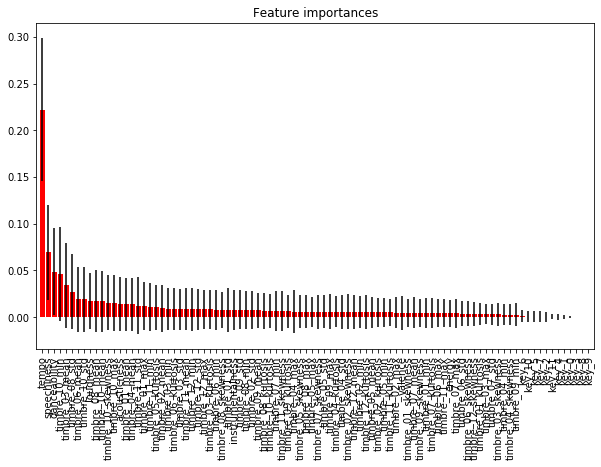

In [28]:
importances = rfc_cv.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_cv.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
f_indices = [data_df.columns[i] for i in indices]

plt.figure(figsize = (10,6))
plt.title("Feature importances")
plt.bar(range(data_df.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(data_df.shape[1]), f_indices, rotation = 90)
plt.xlim([-1, data_df.shape[1]])
plt.show()

**XGBoost**

In [28]:
def get_label_weights(lab_array):
    
    tot = len(y_train)
    class_, counts = np.unique(lab_array, axis=0, return_counts=True)
    count_percent = counts / tot
    
    # divide the percent minimum represented class with the percent of the class
    # itself to get the weight proportional to the least represented class
    min_ = min(count_percent)
    count_w = [round(min_/x, 2) for x in count_percent]
    # create dictionary with label : weight pairs
    class_weights = { str(cls): count for cls, count in zip(class_, count_w)}
    # make a list of weights for corresponding labels from lab_array
    weights = [class_weights[str(lab)] for lab in lab_array]

    return weights

In [29]:
train_weights = get_label_weights(y_train)
print(len(train_weights))
train_weights[:10]

279


[0.54, 0.54, 0.48, 0.93, 0.48, 0.76, 0.87, 0.35, 0.65, 0.65]

In [30]:
D_train = xgb.DMatrix(x_train, label=y_train, weight=train_weights)
D_test = xgb.DMatrix(x_test, label=y_test)

In [34]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'colsample_bytree': 1,
    'eta':.1,
    # Other parameters
    'min_child_weight': 1,
    'subsample': 1,
    'objective':'multi:softmax',
    'eval_metric':'merror',
    'num_class':13
}

In [35]:
NUM_BOOST_ROUND = 999
SEED = 50
gridsearch_params = [
    (max_depth, colsample_bytree, colsample_bylevel, eta, gamma)
    for max_depth in [3, 6, 12]
    for colsample_bytree in [0.75, 1]
    for colsample_bylevel in [0.75, 1]
    for eta in [0.1, 0.15, 0.20, 0.25]
    for gamma in [0, 1, 3, 5]
]

In [36]:
start_time = timer(None) # timing starts from this point
# Define initial best params and ERROR
min_error = float("Inf")
best_params = None
for max_depth, colsample_bytree, colsample_bylevel, eta, gamma in gridsearch_params:
    print("CV with max_depth = {}, colsample_bytree = {}, eta = {}".format(
                             max_depth, 
                             colsample_bytree,
                             colsample_bylevel,
                             eta,
                             gamma)
    )
    # Update our parameters
    params['max_depth'] = max_depth
    params['colsample_bytree'] = colsample_bytree
    params['colsample_bylevel'] = colsample_bylevel
    params['eta'] = eta
    params['gamma'] = gamma

    # Run CV
    
    cv_results = xgb.cv(
        params,
        D_train,
        num_boost_round=NUM_BOOST_ROUND,
        seed=SEED,
        nfold=10,
        stratified=True,
        metrics={'merror'},
        early_stopping_rounds=50,
        verbose_eval=25
    )

   # Update best error
    mean_error = cv_results['test-merror-mean'].min()
    boost_rounds = cv_results['test-merror-mean'].idxmin()
    print("\n ERROR {} for {} rounds \n".format(mean_error, boost_rounds))

    if mean_error < min_error:
        min_error = mean_error
        best_params = (max_depth, colsample_bytree, colsample_bylevel, eta, gamma)

print("Best params: max_depth = {}, colsample_bytree = {}, colsample_bylevel = {} \n \
                eta = {},  gamma = {} \n ERROR: {} \t boost rounds:{}".format(
                                        best_params[0], best_params[1],
                                        best_params[2], best_params[3], best_params[4],
                                        min_error, boost_rounds)
)

timer(start_time) # timing ends here

CV with max_depth = 3, colsample_bytree = 0.75, eta = 0.75
[0]	train-merror:0.348737+0.0218155	test-merror:0.753229+0.077114
[25]	train-merror:0.0095414+0.00338648	test-merror:0.561721+0.081192
[50]	train-merror:0+0	test-merror:0.539669+0.0753111
[75]	train-merror:0+0	test-merror:0.546779+0.0813283
[100]	train-merror:0+0	test-merror:0.534239+0.101235
[125]	train-merror:0+0	test-merror:0.536509+0.103253
[150]	train-merror:0+0	test-merror:0.527031+0.104508
[175]	train-merror:0+0	test-merror:0.530582+0.117064
[200]	train-merror:0+0	test-merror:0.541595+0.103057

 ERROR 0.5248381 for 166 rounds 

CV with max_depth = 3, colsample_bytree = 0.75, eta = 0.75
[0]	train-merror:0.361036+0.0190238	test-merror:0.752157+0.0893647
[25]	train-merror:0.0402153+0.00632516	test-merror:0.561829+0.0752137
[50]	train-merror:0.0273653+0.00527448	test-merror:0.563032+0.062994
[75]	train-merror:0.0265189+0.00589597	test-merror:0.563032+0.0629941

 ERROR 0.5511611000000001 for 34 rounds 

CV with max_depth = 3,

[0]	train-merror:0.308562+0.0151405	test-merror:0.696952+0.0747606
[25]	train-merror:0.0317337+0.00651841	test-merror:0.565887+0.0791422
[50]	train-merror:0.030643+0.0063116	test-merror:0.575619+0.0770561

 ERROR 0.5628599 for 24 rounds 

CV with max_depth = 3, colsample_bytree = 0.75, eta = 1
[0]	train-merror:0.386812+0.0174867	test-merror:0.691147+0.0729063
[25]	train-merror:0.177245+0.0143524	test-merror:0.583371+0.0514821
[50]	train-merror:0.174213+0.0158323	test-merror:0.587142+0.0514191

 ERROR 0.5820369 for 7 rounds 

CV with max_depth = 3, colsample_bytree = 0.75, eta = 1
[0]	train-merror:0.424886+0.0178048	test-merror:0.674397+0.107689
[25]	train-merror:0.336747+0.0179298	test-merror:0.620843+0.0396409
[50]	train-merror:0.329036+0.0185834	test-merror:0.621713+0.040961

 ERROR 0.6112674 for 7 rounds 

CV with max_depth = 3, colsample_bytree = 0.75, eta = 1
[0]	train-merror:0.298218+0.0149025	test-merror:0.705191+0.0795226
[25]	train-merror:0+0	test-merror:0.566214+0.0895213
[50

[0]	train-merror:0.366+0.0165165	test-merror:0.689292+0.0664025
[25]	train-merror:0.16838+0.0132239	test-merror:0.572266+0.0878573
[50]	train-merror:0.163611+0.014451	test-merror:0.568598+0.0871548

 ERROR 0.5633511999999999 for 12 rounds 

CV with max_depth = 3, colsample_bytree = 1, eta = 0.75
[0]	train-merror:0.41111+0.0184013	test-merror:0.722067+0.100238
[25]	train-merror:0.312916+0.0248521	test-merror:0.606066+0.0918649
[50]	train-merror:0.30818+0.0273417	test-merror:0.609113+0.0881653

 ERROR 0.5973651 for 16 rounds 

CV with max_depth = 3, colsample_bytree = 1, eta = 1
[0]	train-merror:0.269577+0.0207944	test-merror:0.693677+0.0928625
[25]	train-merror:0.0131008+0.00237866	test-merror:0.567939+0.0759797
[50]	train-merror:0.0006325+0.001265	test-merror:0.553296+0.111193
[75]	train-merror:0+0	test-merror:0.548696+0.103432
[100]	train-merror:0+0	test-merror:0.536123+0.116851
[125]	train-merror:0+0	test-merror:0.538298+0.131299
[150]	train-merror:0+0	test-merror:0.538336+0.127814
[

[50]	train-merror:0.146775+0.0140977	test-merror:0.570025+0.0683412

 ERROR 0.5679871 for 10 rounds 

CV with max_depth = 6, colsample_bytree = 0.75, eta = 0.75
[0]	train-merror:0.440289+0.0330846	test-merror:0.746405+0.0689233
[25]	train-merror:0.302619+0.0232273	test-merror:0.595882+0.0614501
[50]	train-merror:0.292584+0.0238174	test-merror:0.592867+0.0702269
[75]	train-merror:0.282798+0.0183179	test-merror:0.590083+0.0647894
[100]	train-merror:0.275556+0.0242704	test-merror:0.601144+0.059443
[125]	train-merror:0.2739+0.0243875	test-merror:0.601144+0.0594431

 ERROR 0.5872613999999999 for 85 rounds 

CV with max_depth = 6, colsample_bytree = 0.75, eta = 0.75
[0]	train-merror:0.298694+0.0217924	test-merror:0.758765+0.0797578
[25]	train-merror:0.0003163+0.0009489	test-merror:0.543984+0.0800284
[50]	train-merror:0+0	test-merror:0.54764+0.0684499
[75]	train-merror:0+0	test-merror:0.554223+0.050745

 ERROR 0.5370099 for 34 rounds 

CV with max_depth = 6, colsample_bytree = 0.75, eta = 0.7


 ERROR 0.6157459000000001 for 17 rounds 

CV with max_depth = 6, colsample_bytree = 1, eta = 0.75
[0]	train-merror:0.264923+0.0213937	test-merror:0.702451+0.101038
[25]	train-merror:0.0039648+0.0012664	test-merror:0.56292+0.0841915
[50]	train-merror:0.0006342+0.0012684	test-merror:0.533288+0.0870456
[75]	train-merror:0+0	test-merror:0.540298+0.0852275

 ERROR 0.5332879 for 50 rounds 

CV with max_depth = 6, colsample_bytree = 1, eta = 0.75
[0]	train-merror:0.274982+0.0214367	test-merror:0.696654+0.0860579
[25]	train-merror:0.0355327+0.00751379	test-merror:0.567989+0.0729713
[50]	train-merror:0.0276084+0.00492895	test-merror:0.546802+0.0737601
[75]	train-merror:0.0269493+0.00555744	test-merror:0.547684+0.0722953
[100]	train-merror:0.0266205+0.00500189	test-merror:0.544717+0.0775906

 ERROR 0.5438629 for 52 rounds 

CV with max_depth = 6, colsample_bytree = 1, eta = 0.75
[0]	train-merror:0.361235+0.0149216	test-merror:0.679841+0.0669826
[25]	train-merror:0.176979+0.016507	test-merror:0.


 ERROR 0.5131173 for 28 rounds 

CV with max_depth = 6, colsample_bytree = 1, eta = 1
[0]	train-merror:0.26769+0.0241136	test-merror:0.679028+0.0849894
[25]	train-merror:0.0300449+0.00668313	test-merror:0.581563+0.0796694
[50]	train-merror:0.0300816+0.00736605	test-merror:0.583614+0.0823094

 ERROR 0.5677339 for 10 rounds 

CV with max_depth = 6, colsample_bytree = 1, eta = 1
[0]	train-merror:0.351625+0.0163811	test-merror:0.687305+0.0859567
[25]	train-merror:0.18476+0.0188103	test-merror:0.616619+0.0641778
[50]	train-merror:0.184531+0.0189592	test-merror:0.616619+0.0641778

 ERROR 0.6049102 for 5 rounds 

CV with max_depth = 6, colsample_bytree = 1, eta = 1
[0]	train-merror:0.39803+0.0202519	test-merror:0.672098+0.100237
[25]	train-merror:0.347956+0.0191826	test-merror:0.633556+0.0645922
[50]	train-merror:0.347639+0.0200426	test-merror:0.638128+0.0620995

 ERROR 0.6308440999999999 for 1 rounds 

CV with max_depth = 6, colsample_bytree = 1, eta = 1
[0]	train-merror:0.252224+0.0239002	

[25]	train-merror:0.0331909+0.0108869	test-merror:0.575036+0.0816487
[50]	train-merror:0.0245221+0.0061028	test-merror:0.576071+0.0769365
[75]	train-merror:0.0238635+0.00637323	test-merror:0.576071+0.0769365

 ERROR 0.5686602 for 30 rounds 

CV with max_depth = 12, colsample_bytree = 0.75, eta = 1
[0]	train-merror:0.37891+0.024439	test-merror:0.697074+0.0672991
[25]	train-merror:0.179254+0.020276	test-merror:0.579535+0.05744
[50]	train-merror:0.173303+0.0179604	test-merror:0.562448+0.0572349
[75]	train-merror:0.170687+0.0137899	test-merror:0.564251+0.0502146

 ERROR 0.5624482 for 46 rounds 

CV with max_depth = 12, colsample_bytree = 0.75, eta = 1
[0]	train-merror:0.421388+0.0187527	test-merror:0.680403+0.105835
[25]	train-merror:0.342607+0.0266205	test-merror:0.632575+0.0382748
[50]	train-merror:0.337785+0.0292836	test-merror:0.632575+0.0382748

 ERROR 0.6139094 for 7 rounds 

CV with max_depth = 12, colsample_bytree = 0.75, eta = 1
[0]	train-merror:0.281257+0.0242834	test-merror:0.69

[0]	train-merror:0.361235+0.0149216	test-merror:0.679841+0.0669826
[25]	train-merror:0.175752+0.0201316	test-merror:0.596319+0.0762147
[50]	train-merror:0.170275+0.0178982	test-merror:0.595677+0.0817285

 ERROR 0.5663073 for 6 rounds 

CV with max_depth = 12, colsample_bytree = 1, eta = 0.75
[0]	train-merror:0.40901+0.018514	test-merror:0.717614+0.0995005
[25]	train-merror:0.314871+0.0282349	test-merror:0.622824+0.0701181
[50]	train-merror:0.308642+0.0250722	test-merror:0.626595+0.0749863

 ERROR 0.6125832 for 5 rounds 

CV with max_depth = 12, colsample_bytree = 1, eta = 0.75
[0]	train-merror:0.264923+0.0213937	test-merror:0.702451+0.101038
[25]	train-merror:0+0	test-merror:0.566736+0.0989036
[50]	train-merror:0+0	test-merror:0.542428+0.13266
[75]	train-merror:0+0	test-merror:0.545884+0.123931
[100]	train-merror:0+0	test-merror:0.541714+0.131446

 ERROR 0.5289569000000001 for 59 rounds 

CV with max_depth = 12, colsample_bytree = 1, eta = 0.75
[0]	train-merror:0.274982+0.0214367	test-

In [37]:
bst_p = best_params
bst_p

(12, 1, 1, 0.2, 0)

In [38]:

params_ = {
    # Parameters that we are going to tune.
    'max_depth':12,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'eta':0.2,
    'gamma': 0,
    # Other parameters
    'objective':'multi:softmax',
    'eval_metric':'merror',
    'num_class':13
}
model = xgb.train(
    params_,
    D_train,
    num_boost_round=20,
    verbose_eval=5
)

print(' Accuracy on training data : \n' , classification_report(D_train.get_label(), model.predict(D_train), target_names=enc_categories))
print(' Accuracy on test data : \n' , classification_report(D_test.get_label(), model.predict(D_test), target_names=enc_categories))

 Accuracy on training data : 
                            precision    recall  f1-score   support

      Classic progressive       1.00      1.00      1.00        26
               Deep house       1.00      1.00      1.00        20
             House-Trance       1.00      1.00      1.00        37
    Our old school trance       1.00      1.00      1.00        27
Our old school trance 138       1.00      1.00      1.00        14
  Our old school trance 2       1.00      1.00      1.00        17
            Progressive 1       1.00      1.00      1.00        13
            Progressive 2       1.00      1.00      1.00        20
            Progressive 3       1.00      1.00      1.00        16
            Progressive 4       1.00      1.00      1.00        24
            Progressive 5       1.00      1.00      1.00        13
        Progressive House       1.00      1.00      1.00        15
     That familiar trance       1.00      1.00      1.00        37

                 accuracy    

In [57]:
f_imp = sorted(model.get_fscore().items(), key=lambda y: y[1], reverse=True)
f = [x[0] for x in f_imp]
y = [x[1] for x in f_imp]

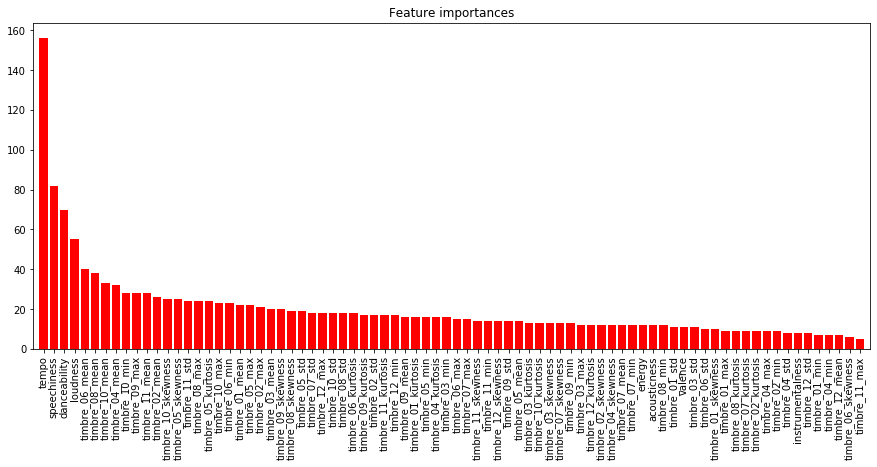

In [66]:
plt.figure(figsize = (15,6))
plt.title("Feature importances")
plt.bar(f, y, color="r", align="center")
plt.xticks(range(len(f)), f, rotation = 90)
plt.xlim([-1, len(f)])
plt.show()

In [32]:
fil_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'valence', 'tempo', 'timbre_01_mean', 'timbre_02_mean', 'timbre_03_mean',
       'timbre_04_mean', 'timbre_05_mean', 'timbre_06_mean', 'timbre_07_mean',
       'timbre_08_mean', 'timbre_09_mean', 'timbre_10_mean', 'timbre_11_mean',
       'timbre_12_mean']
upd_x_train = x_train.loc[:, fil_cols]
upd_x_test = x_test.loc[:, fil_cols]


In [33]:
upd_D_train = xgb.DMatrix(upd_x_train, label=y_train, weight=train_weights)
upd_D_test = xgb.DMatrix(upd_x_test, label=y_test)

In [72]:
start_time = timer(None) # timing starts from this point
# Define initial best params and ERROR
min_error = float("Inf")
best_params = None
for max_depth, colsample_bytree, colsample_bylevel, eta, gamma in gridsearch_params:
    print("CV with max_depth = {}, colsample_bytree = {}, eta = {}".format(
                             max_depth, 
                             colsample_bytree,
                             colsample_bylevel,
                             eta,
                             gamma)
    )
    # Update our parameters
    params['max_depth'] = max_depth
    params['colsample_bytree'] = colsample_bytree
    params['colsample_bylevel'] = colsample_bylevel
    params['eta'] = eta
    params['gamma'] = gamma

    # Run CV
    
    cv_results = xgb.cv(
        params,
        upd_D_train,
        num_boost_round=NUM_BOOST_ROUND,
        seed=SEED,
        nfold=10,
        stratified=True,
        metrics={'merror'},
        early_stopping_rounds=50,
        verbose_eval=25
    )

   # Update best error
    mean_error = cv_results['test-merror-mean'].min()
    boost_rounds = cv_results['test-merror-mean'].idxmin()
    print("\n ERROR {} for {} rounds \n".format(mean_error, boost_rounds))

    if mean_error < min_error:
        min_error = mean_error
        best_params = (max_depth, colsample_bytree, colsample_bylevel, eta, gamma)

print("Best params: max_depth = {}, colsample_bytree = {}, colsample_bylevel = {} \n \
                eta = {},  gamma = {} \n ERROR: {} \t boost rounds:{}".format(
                                        best_params[0], best_params[1],
                                        best_params[2], best_params[3], best_params[4],
                                        min_error, boost_rounds)
)

timer(start_time) # timing ends here

CV with max_depth = 3, colsample_bytree = 0.75, eta = 0.75
[0]	train-merror:0.402577+0.0292557	test-merror:0.69233+0.0833385
[25]	train-merror:0.0354475+0.00753773	test-merror:0.540328+0.100439
[50]	train-merror:0.007353+0.00222726	test-merror:0.529706+0.0973672
[75]	train-merror:0.0006332+0.0012664	test-merror:0.513101+0.081645
[100]	train-merror:0+0	test-merror:0.508981+0.0771275
[125]	train-merror:0+0	test-merror:0.507252+0.0791387

 ERROR 0.5060536 for 86 rounds 

CV with max_depth = 3, colsample_bytree = 0.75, eta = 0.75
[0]	train-merror:0.411111+0.0262969	test-merror:0.691499+0.0947
[25]	train-merror:0.0809718+0.0084249	test-merror:0.546216+0.0829724
[50]	train-merror:0.0711447+0.0080913	test-merror:0.536043+0.0973433
[75]	train-merror:0.0663655+0.00897516	test-merror:0.541745+0.0926486

 ERROR 0.530324 for 42 rounds 

CV with max_depth = 3, colsample_bytree = 0.75, eta = 0.75
[0]	train-merror:0.461179+0.0254531	test-merror:0.700575+0.0705487
[25]	train-merror:0.265702+0.0194047	

[25]	train-merror:0.411713+0.0224452	test-merror:0.605586+0.0582078
[50]	train-merror:0.402588+0.0249532	test-merror:0.616682+0.0568722

 ERROR 0.5934843 for 2 rounds 

CV with max_depth = 3, colsample_bytree = 0.75, eta = 1
[0]	train-merror:0.382029+0.0139513	test-merror:0.677048+0.0657892
[25]	train-merror:0.0046707+0.0023958	test-merror:0.558085+0.0893388
[50]	train-merror:0+0	test-merror:0.541743+0.0708095
[75]	train-merror:0+0	test-merror:0.535466+0.0649525
[100]	train-merror:0+0	test-merror:0.537995+0.059568
[125]	train-merror:0+0	test-merror:0.529742+0.0646681
[150]	train-merror:0+0	test-merror:0.535625+0.068622
[175]	train-merror:0+0	test-merror:0.5376+0.0695517

 ERROR 0.526813 for 128 rounds 

CV with max_depth = 3, colsample_bytree = 0.75, eta = 1
[0]	train-merror:0.395068+0.0169785	test-merror:0.689477+0.0569127
[25]	train-merror:0.0735659+0.0106735	test-merror:0.569695+0.111794
[50]	train-merror:0.0704611+0.0109131	test-merror:0.570302+0.110164

 ERROR 0.5586591000000001 f

[25]	train-merror:0.244808+0.0200896	test-merror:0.585558+0.0576125
[50]	train-merror:0.242634+0.0204578	test-merror:0.585558+0.0576125

 ERROR 0.5691596 for 10 rounds 

CV with max_depth = 3, colsample_bytree = 1, eta = 0.75
[0]	train-merror:0.478555+0.0312701	test-merror:0.658279+0.0570095
[25]	train-merror:0.373268+0.0387095	test-merror:0.585828+0.0713419
[50]	train-merror:0.366053+0.036849	test-merror:0.583237+0.0753238
[75]	train-merror:0.360971+0.0324029	test-merror:0.590286+0.0641965

 ERROR 0.5773025 for 42 rounds 

CV with max_depth = 3, colsample_bytree = 1, eta = 1
[0]	train-merror:0.317278+0.0164728	test-merror:0.649714+0.0705887
[25]	train-merror:0.0388612+0.00461455	test-merror:0.558028+0.0856377
[50]	train-merror:0.0071369+0.00269462	test-merror:0.565806+0.0776362
[75]	train-merror:0.0006326+0.0012652	test-merror:0.521578+0.0890294
[100]	train-merror:0+0	test-merror:0.525105+0.0843098
[125]	train-merror:0+0	test-merror:0.510131+0.0837736
[150]	train-merror:0+0	test-merro


 ERROR 0.5081532 for 48 rounds 

CV with max_depth = 6, colsample_bytree = 0.75, eta = 0.75
[0]	train-merror:0.366802+0.0207205	test-merror:0.685231+0.0857591
[25]	train-merror:0.0632233+0.0101891	test-merror:0.574398+0.0991982
[50]	train-merror:0.0559075+0.00745108	test-merror:0.560597+0.0968076
[75]	train-merror:0.0519156+0.00794003	test-merror:0.555422+0.0951557
[100]	train-merror:0.0525708+0.00826843	test-merror:0.548412+0.0964322
[125]	train-merror:0.0494147+0.00685566	test-merror:0.555342+0.0964437

 ERROR 0.5484116 for 91 rounds 

CV with max_depth = 6, colsample_bytree = 0.75, eta = 0.75
[0]	train-merror:0.446391+0.0224339	test-merror:0.702234+0.0621243
[25]	train-merror:0.235535+0.0158616	test-merror:0.565341+0.0661057
[50]	train-merror:0.224073+0.0166867	test-merror:0.586001+0.074551

 ERROR 0.5594621 for 17 rounds 

CV with max_depth = 6, colsample_bytree = 0.75, eta = 0.75
[0]	train-merror:0.520117+0.032621	test-merror:0.738767+0.0946299
[25]	train-merror:0.358605+0.024591

[25]	train-merror:0.0003168+0.0009504	test-merror:0.526035+0.0833593
[50]	train-merror:0+0	test-merror:0.521608+0.0707521
[75]	train-merror:0+0	test-merror:0.510815+0.0635357
[100]	train-merror:0+0	test-merror:0.505369+0.0699876

 ERROR 0.5036452 for 68 rounds 

CV with max_depth = 6, colsample_bytree = 0.75, eta = 1
[0]	train-merror:0.358596+0.0227943	test-merror:0.698588+0.0497223
[25]	train-merror:0.0634581+0.0118188	test-merror:0.576784+0.100506
[50]	train-merror:0.0581646+0.0110733	test-merror:0.573781+0.0989116

 ERROR 0.5688705000000001 for 9 rounds 

CV with max_depth = 6, colsample_bytree = 0.75, eta = 1
[0]	train-merror:0.42891+0.0174326	test-merror:0.676312+0.0408155
[25]	train-merror:0.23431+0.012312	test-merror:0.572742+0.0657174
[50]	train-merror:0.232433+0.0133662	test-merror:0.567156+0.069221

 ERROR 0.5625442 for 6 rounds 

CV with max_depth = 6, colsample_bytree = 0.75, eta = 1
[0]	train-merror:0.499706+0.0307897	test-merror:0.682402+0.0658689
[25]	train-merror:0.3788

[100]	train-merror:0+0	test-merror:0.527686+0.0577523

 ERROR 0.5203278 for 73 rounds 

CV with max_depth = 6, colsample_bytree = 1, eta = 1
[0]	train-merror:0.299687+0.0194175	test-merror:0.667784+0.0560987
[25]	train-merror:0.0688629+0.00654324	test-merror:0.566169+0.0859921
[50]	train-merror:0.0677393+0.00672978	test-merror:0.569227+0.0901908

 ERROR 0.5661690000000001 for 23 rounds 

CV with max_depth = 6, colsample_bytree = 1, eta = 1
[0]	train-merror:0.379354+0.0194203	test-merror:0.645136+0.053131
[25]	train-merror:0.280649+0.0202779	test-merror:0.590098+0.0754881
[50]	train-merror:0.280649+0.0202779	test-merror:0.590098+0.0754881

 ERROR 0.5882733 for 4 rounds 

CV with max_depth = 6, colsample_bytree = 1, eta = 1
[0]	train-merror:0.419307+0.0245358	test-merror:0.61866+0.0684704
[25]	train-merror:0.442549+0.0220784	test-merror:0.600448+0.0813783
[50]	train-merror:0.444096+0.0211785	test-merror:0.600448+0.0813783

 ERROR 0.6000248 for 2 rounds 

CV with max_depth = 6, colsample_

[25]	train-merror:0.001267+0.00155176	test-merror:0.531998+0.0801058
[50]	train-merror:0+0	test-merror:0.531722+0.0626009
[75]	train-merror:0+0	test-merror:0.53605+0.0682445

 ERROR 0.5225283000000001 for 28 rounds 

CV with max_depth = 12, colsample_bytree = 0.75, eta = 0.75
[0]	train-merror:0.366802+0.0207205	test-merror:0.685231+0.0857591
[25]	train-merror:0.0533492+0.00904008	test-merror:0.563059+0.0691144
[50]	train-merror:0.0492738+0.00918513	test-merror:0.551256+0.0831235
[75]	train-merror:0.0466903+0.0109611	test-merror:0.548547+0.0822997
[100]	train-merror:0.0463621+0.0109057	test-merror:0.550605+0.0860599

 ERROR 0.5485472 for 57 rounds 

CV with max_depth = 12, colsample_bytree = 0.75, eta = 0.75
[0]	train-merror:0.446391+0.0224339	test-merror:0.702234+0.0621243
[25]	train-merror:0.231691+0.0230633	test-merror:0.563558+0.0655384
[50]	train-merror:0.218515+0.0191252	test-merror:0.578649+0.0766287

 ERROR 0.5622406999999999 for 12 rounds 

CV with max_depth = 12, colsample_byt

[0]	train-merror:0.44971+0.0347482	test-merror:0.646329+0.0577882
[25]	train-merror:0.389528+0.0198269	test-merror:0.624654+0.0548225
[50]	train-merror:0.375915+0.0192768	test-merror:0.614593+0.0497395

 ERROR 0.5886038 for 2 rounds 

CV with max_depth = 12, colsample_bytree = 1, eta = 0.75
[0]	train-merror:0.306261+0.0176849	test-merror:0.652933+0.0386202
[25]	train-merror:0.0037323+0.00113095	test-merror:0.54739+0.0878864
[50]	train-merror:0+0	test-merror:0.527744+0.0877126
[75]	train-merror:0+0	test-merror:0.525193+0.088827
[100]	train-merror:0+0	test-merror:0.526896+0.0810177
[125]	train-merror:0+0	test-merror:0.522893+0.0825947
[150]	train-merror:0+0	test-merror:0.522893+0.0825947

 ERROR 0.5178026 for 116 rounds 

CV with max_depth = 12, colsample_bytree = 1, eta = 0.75
[0]	train-merror:0.31953+0.0177133	test-merror:0.63841+0.0524486
[25]	train-merror:0.0664124+0.0128903	test-merror:0.557019+0.0758898
[50]	train-merror:0.0626233+0.0128185	test-merror:0.565664+0.0789046

 ERROR 0.

[0]	train-merror:0.419307+0.0245358	test-merror:0.61866+0.0684704
[25]	train-merror:0.430083+0.0106161	test-merror:0.624754+0.0823967
[50]	train-merror:0.429753+0.0106456	test-merror:0.621814+0.0794542

 ERROR 0.5922221 for 1 rounds 

CV with max_depth = 12, colsample_bytree = 1, eta = 1
[0]	train-merror:0.278468+0.0201621	test-merror:0.682815+0.0468638
[25]	train-merror:0.0009494+0.00145023	test-merror:0.536729+0.0789519
[50]	train-merror:0+0	test-merror:0.536796+0.0674487

 ERROR 0.5367292000000001 for 25 rounds 

CV with max_depth = 12, colsample_bytree = 1, eta = 1
[0]	train-merror:0.299687+0.0194175	test-merror:0.667784+0.0560987
[25]	train-merror:0.0713736+0.00978645	test-merror:0.553876+0.0786289
[50]	train-merror:0.0716439+0.0100312	test-merror:0.553876+0.078629

 ERROR 0.553107 for 8 rounds 

CV with max_depth = 12, colsample_bytree = 1, eta = 1
[0]	train-merror:0.379354+0.0194203	test-merror:0.645136+0.053131
[25]	train-merror:0.273907+0.0280016	test-merror:0.593436+0.0809369

In [73]:
upd_bst_p = best_params
upd_bst_p

(6, 0.75, 1, 0.1, 0)

In [34]:

params_ = {
    # Parameters that we are going to tune.
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 0.75,
    'colsample_bylevel': 1,
    'eta': 0.1,
    'gamma': 0,
    # Other parameters
    'objective':'multi:softmax',
    'eval_metric':'merror',
    'num_class':13
}
model2 = xgb.train(
    params_,
    upd_D_train,
    num_boost_round=20,
    verbose_eval=5
)

print(' Accuracy on training data : \n' , classification_report(upd_D_train.get_label(), model2.predict(upd_D_train), target_names=enc_categories))
print(' Accuracy on test data : \n' , classification_report(upd_D_test.get_label(), model2.predict(upd_D_test), target_names=enc_categories))

 Accuracy on training data : 
                            precision    recall  f1-score   support

      Classic progressive       0.96      0.92      0.94        26
               Deep house       0.95      1.00      0.98        20
             House-Trance       0.97      0.97      0.97        37
    Our old school trance       1.00      0.96      0.98        27
Our old school trance 138       1.00      1.00      1.00        14
  Our old school trance 2       1.00      1.00      1.00        17
            Progressive 1       0.93      1.00      0.96        13
            Progressive 2       1.00      1.00      1.00        20
            Progressive 3       0.94      1.00      0.97        16
            Progressive 4       1.00      1.00      1.00        24
            Progressive 5       1.00      1.00      1.00        13
        Progressive House       0.94      1.00      0.97        15
     That familiar trance       1.00      0.95      0.97        37

                 accuracy    

In [36]:
f_imp = sorted(model2.get_fscore().items(), key=lambda y: y[1], reverse=True)
f = [x[0] for x in f_imp]
y = [x[1] for x in f_imp]

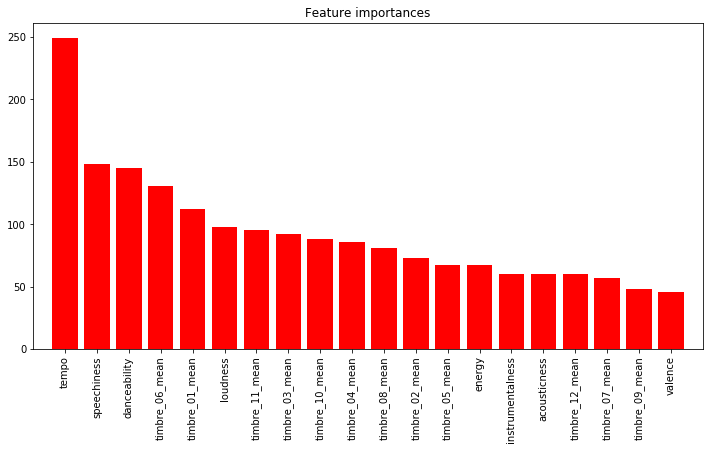

In [38]:
plt.figure(figsize = (12,6))
plt.title("Feature importances")
plt.bar(f, y, color="r", align="center")
plt.xticks(range(len(f)), f, rotation = 90)
plt.xlim([-1, len(f)])
plt.show()

#### K- Neighbors Classifier

In [ ]:
clf = KNeighborsClassifier()

hpar = { 'n_neighbors' : [3, 5, 7], 'weights' : ['uniform', 'distance'],
         'p' : [1, 2 ,4],  'leaf_size' : [20, 30, 40]}

clf = GridSearchCV( clf , param_grid = hpar, cv = 5)

clf.fit(data_train, y_train)

print(clf.best_params_)

In [ ]:
print(' Accuracy on training data : \n' , classification_report(y_train, clf.predict(data_train), target_names=enc_categories))
print(' Accuracy on test data : \n' , classification_report(y_test, clf.predict(data_test), target_names=enc_categories))